In [2]:
# Импорт необходимых библиотек
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import json
import time
import os


In [25]:

# Конфигурация параметров
BASE_DIR = 'data'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed')
IMG_SIZE = (224, 224)
INPUT_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-4  # Уменьшенный learning rate

# Загрузка соответствия классов и индексов
with open(os.path.join(PROCESSED_DIR, 'class_indices.json'), 'r') as f:
    class_indices = json.load(f)
    
class_names = list(class_indices.keys())
NUM_CLASSES = len(class_names)
print(f"Количество классов: {NUM_CLASSES}")
print("Названия классов:", class_names)


Количество классов: 9
Названия классов: ['Bacteria', 'Early_blight', 'Fungi', 'Healthy', 'Late_blight', 'Nematode', 'Pest', 'Phytopthora', 'Virus']


In [26]:

# Создание генераторов с правильным препроцессингом для EfficientNet
def create_generators():
    # Генератор для тренировки с аугментацией
    train_datagen = ImageDataGenerator(
        rotation_range=8,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.02,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        brightness_range=[0.95, 1.05],
        fill_mode='reflect',
        preprocessing_function=preprocess_input  # Специфичный препроцессинг
    )
    
    # Генераторы для валидации и теста
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    # Создание генераторов
    train_generator = train_datagen.flow_from_directory(
        os.path.join(PROCESSED_DIR, 'train'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_directory(
        os.path.join(PROCESSED_DIR, 'val'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = test_datagen.flow_from_directory(
        os.path.join(PROCESSED_DIR, 'test'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator

# Создаем генераторы
train_generator, val_generator, test_generator = create_generators()

print("\nГенераторы успешно созданы:")
print(f"Train: {train_generator.samples} изображений")
print(f"Validation: {val_generator.samples} изображений")
print(f"Test: {test_generator.samples} изображений")


Found 3658 images belonging to 9 classes.
Found 785 images belonging to 9 classes.
Found 785 images belonging to 9 classes.

Генераторы успешно созданы:
Train: 3658 изображений
Validation: 785 изображений
Test: 785 изображений



Проверка данных из генератора:
Размер батча изображений: (32, 224, 224, 3)
Диапазон значений пикселей: min=0.0, max=255.0
Размер батча меток: (32, 9)


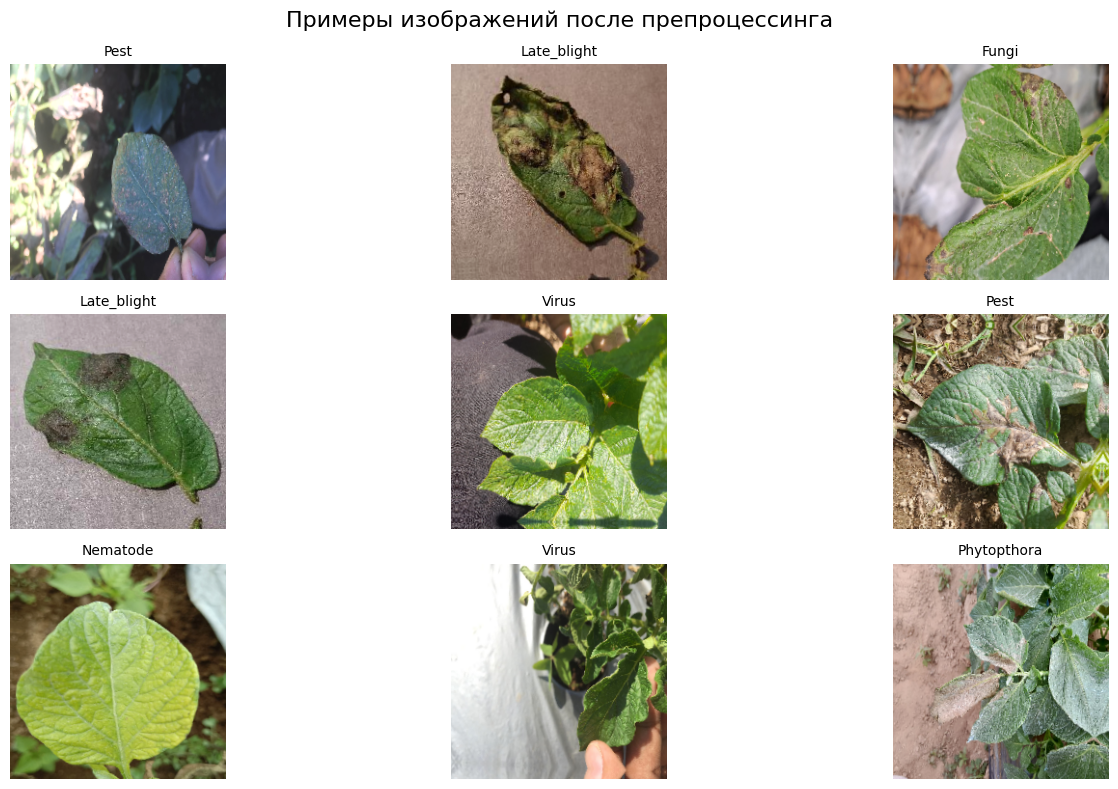

In [27]:

# Проверка данных из генератора
batch_images, batch_labels = next(train_generator)
print("\nПроверка данных из генератора:")
print(f"Размер батча изображений: {batch_images.shape}")
print(f"Диапазон значений пикселей: min={batch_images.min()}, max={batch_images.max()}")
print(f"Размер батча меток: {batch_labels.shape}")

# Визуализация примеров
plt.figure(figsize=(15, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = batch_images[i].copy()
    
    # Денормализация для отображения
    img += abs(img.min())  # Смещаем в положительный диапазон
    img /= img.max()       # Нормализуем к [0,1]
    
    plt.imshow(img)
    class_idx = np.argmax(batch_labels[i])
    class_name = list(train_generator.class_indices.keys())[class_idx]
    plt.title(class_name, fontsize=10)
    plt.axis('off')
plt.suptitle('Примеры изображений после препроцессинга', fontsize=16)
plt.tight_layout()
plt.show()

# Создание модели с частично размороженными слоями
def create_model():
    # Загрузка предобученной модели EfficientNetB0
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=INPUT_SHAPE,
        pooling='avg'
    )
    
    # Частичное размораживание слоев
    base_model.trainable = True
    
    # Замораживаем первые 150 слоев
    for layer in base_model.layers[:150]:
        layer.trainable = False
    
    # Размораживаем последние слои
    for layer in base_model.layers[150:]:
        layer.trainable = True
    
    # Создаем полную модель
    inputs = tf.keras.Input(shape=INPUT_SHAPE)
    x = base_model(inputs, training=True)  # Важно для BatchNormalization
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    
    return model

# Создаем и компилируем модель
model = create_model()


In [28]:

# Используем оптимизатор с уменьшенным learning rate
optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Конфигурация обучения
MODEL_SAVE_PATH = 'models/best_model.h5'
TFLITE_MODEL_PATH = 'models/model_quant.tflite'

# Определение колбэков
callbacks = [
    ModelCheckpoint(
        MODEL_SAVE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Расчет шагов для генераторов
train_steps = int(np.ceil(train_generator.samples / BATCH_SIZE))
val_steps = int(np.ceil(val_generator.samples / BATCH_SIZE))

# Обучение модели
print("Начало обучения модели...")
start_time = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\nОбучение завершено за {training_time/60:.2f} минут")


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,380,844 (16.71 MB)

 Trainable params: 3,618,465 (13.80 MB)

 Non-trainable params: 762,379 (2.91 MB)

Начало обучения модели...
Epoch 1/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4405 - loss: 1.7991
Epoch 1: val_accuracy improved from -inf to 0.74013, saving model to models/best_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.4417 - loss: 1.7944 - val_accuracy: 0.7401 - val_loss: 0.8744 - learning_rate: 1.0000e-04
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7909 - loss: 0.6149
Epoch 2: val_accuracy improved from 0.74013 to 0.82803, saving model to models/best_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.7910 - loss: 0.6146 - val_accuracy: 0.8280 - val_loss: 0.5161 - learning_rate: 1.0000e-04
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8435 - loss: 0.4260
Epoch 3: val_accuracy improved from 0.82803 to 0.86115, saving model to models/best_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.8436 - loss: 0.4258 - val_accuracy: 0.8611 - val_loss: 0.4089 - learning_rate: 1.0000e-04
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8806 - loss: 0.3311
Epoch 4: val_accuracy improved from 0.86115 to 0.86497, saving model to models/best_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.8806 - loss: 0.3309 - val_accuracy: 0.8650 - val_loss: 0.3862 - learning_rate: 1.0000e-04
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9123 - loss: 0.2474
Epoch 5: val_accuracy improved from 0.86497 to 0.87261, saving model to models/best_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.9122 - loss: 0.2474 - val_accuracy: 0.8726 - val_loss: 0.3883 - learning_rate: 1.0000e-04
Epoch 6/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9411 - loss: 0.1873
Epoch 6: val_accuracy improved from 0.87261 to 0.87898, saving model to models/best_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9410 - loss: 0.1873 - val_accuracy: 0.8790 - val_loss: 0.3650 - learning_rate: 1.0000e-04
Epoch 7/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9445 - loss: 0.1659
Epoch 7: val_accuracy did not improve from 0.87898
115/115 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9445 - loss: 0.1658 - val_accuracy: 0.8688 - val_loss: 0.3865 - learning_rate: 1.0000e-04
Epoch 8/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9516 - loss: 0.1448
Epoch 8: val_accuracy improved from 0.87898 to 0.88535, saving model to models/best_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9516 - loss: 0.1448 - val_accuracy: 0.8854 - val_loss: 0.3763 - learning_rate: 1.0000e-04
Epoch 9/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9679 - loss: 0.1084
Epoch 9: val_accuracy improved from 0.88535 to 0.89045, saving model to models/best_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.9679 - loss: 0.1084 - val_accuracy: 0.8904 - val_loss: 0.3585 - learning_rate: 1.0000e-04
Epoch 10/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9613 - loss: 0.1125
Epoch 10: val_accuracy improved from 0.89045 to 0.89299, saving model to models/best_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.9614 - loss: 0.1124 - val_accuracy: 0.8930 - val_loss: 0.3747 - learning_rate: 1.0000e-04
Epoch 11/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9764 - loss: 0.0787
Epoch 11: val_accuracy improved from 0.89299 to 0.89936, saving model to models/best_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.9764 - loss: 0.0787 - val_accuracy: 0.8994 - val_loss: 0.3554 - learning_rate: 1.0000e-04
Epoch 12/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9792 - loss: 0.0736
Epoch 12: val_accuracy did not improve from 0.89936
115/115 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9792 - loss: 0.0736 - val_accuracy: 0.8904 - val_loss: 0.3714 - learning_rate: 1.0000e-04
Epoch 13/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9773 - loss: 0.0750
Epoch 13: val_accuracy did not improve from 0.89936
115/115 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.9773 - loss: 0.0750 - val_accuracy: 0.8917 - val_loss: 0.3758 - learning_rate: 1.0000e-04
Epoch 14/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9850 - loss: 0.0540
Epoch 14: val_accuracy did not improve from 0.89936

Epoch 14: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
115/115 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9849 - loss: 


Epoch 17: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
115/115 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.9891 - loss: 0.0387 - val_accuracy: 0.9032 - val_loss: 0.3611 - learning_rate: 2.0000e-05
Epoch 18/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9890 - loss: 0.0431
Epoch 18: val_accuracy did not improve from 0.90318
115/115 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.9890 - loss: 0.0431 - val_accuracy: 0.9019 - val_loss: 0.3609 - learning_rate: 4.0000e-06
Epoch 19/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9857 - loss: 0.0465
Epoch 19: val_accuracy did not improve from 0.90318
115/115 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.9858 - loss: 0.0465 - val_accuracy: 0.9019 - val_loss: 0.3601 - learning_rate: 4.0000e-06
Epoch 20/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9932 - loss: 0.0353
Epoch 20: val_accuracy did not improve from 0.90318

Epoch 20: ReduceLROnPlateau reducing learning rate to 1e-06.
115/115 

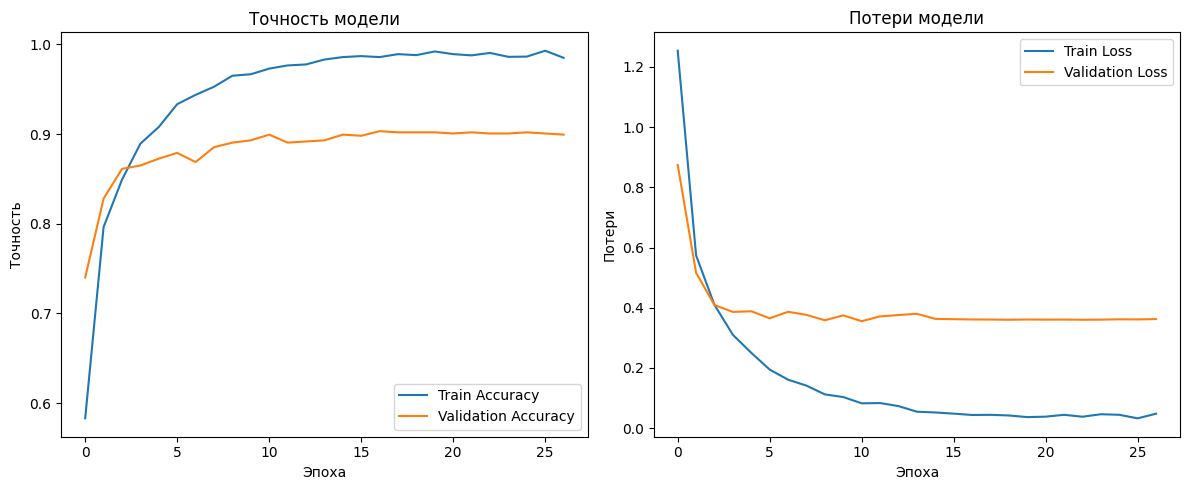

In [29]:

# Визуализация процесса обучения
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Точность модели')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Потери модели')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.legend()

plt.tight_layout()
plt.savefig('models/training_history.png')
plt.show()


In [30]:

# Оценка модели на тестовых данных
print("\nОценка модели на тестовых данных...")
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\nТочность на тестовых данных: {test_acc*100:.2f}%")
print(f"Потери на тестовых данных: {test_loss:.4f}")

# Конвертация в TFLite с квантованием
def convert_to_tflite(model_path, tflite_path):
    # Загрузка модели
    model = tf.keras.models.load_model(model_path)
    
    # Конвертация в TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    # Оптимизации и квантование
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    # Представительский датасет для квантования
    def representative_dataset():
        for _ in range(100):
            batch = next(train_generator)
            yield [batch[0].astype(np.float32)]
    
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8
    
    # Конвертация
    tflite_model = converter.convert()
    
    # Сохранение модели
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    
    return tflite_path

# Конвертируем модель
print("\nКонвертация модели в TFLite с квантованием...")
tflite_model_path = convert_to_tflite(MODEL_SAVE_PATH, TFLITE_MODEL_PATH)
print(f"Модель успешно конвертирована и сохранена как {tflite_model_path}")

# Проверка размера модели
def get_model_size(path):
    size_bytes = os.path.getsize(path)
    size_mb = size_bytes / (1024 * 1024)
    return size_mb

original_size = get_model_size(MODEL_SAVE_PATH)
quantized_size = get_model_size(TFLITE_MODEL_PATH)

print(f"\nРазмеры моделей:")
print(f"Оригинальная модель: {original_size:.2f} MB")
print(f"Квантованная TFLite модель: {quantized_size:.2f} MB")
print(f"Коэффициент сжатия: {original_size/quantized_size:.1f}x")



Оценка модели на тестовых данных...
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9396 - loss: 0.2373

Точность на тестовых данных: 89.68%
Потери на тестовых данных: 0.3375

Конвертация модели в TFLite с квантованием...


INFO:tensorflow:Assets written to: C:\Users\statv\AppData\Local\Temp\tmp765y60qx\assets


INFO:tensorflow:Assets written to: C:\Users\statv\AppData\Local\Temp\tmp765y60qx\assets


Saved artifact at 'C:\Users\statv\AppData\Local\Temp\tmp765y60qx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_11')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  2752583961872: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2752583961680: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2752583963408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2752583963792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2752583964752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2752583963984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2752583959376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2752583965712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2752583965328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2752583966672: TensorSpec(shape=(), dtype=tf.resource

C:\Users\statv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Модель успешно конвертирована и сохранена как models/model_quant.tflite

Размеры моделей:
Оригинальная модель: 44.85 MB
Квантованная TFLite модель: 5.00 MB
Коэффициент сжатия: 9.0x


In [31]:

# Сохранение отчета о модели
def save_model_report():
    report = {
        "test_accuracy": float(test_acc),
        "model_size_mb": float(quantized_size),
        "classes": class_names,
        "input_shape": list(IMG_SIZE),
        "quantization": "INT8",
        "training_time_min": float(training_time/60)
    }
    
    with open('models/model_report.json', 'w') as f:
        json.dump(report, f, indent=2)
    return report

print("\nСохранение отчета...")
model_report = save_model_report()
print(json.dumps(model_report, indent=2))


Сохранение отчета...
{
  "test_accuracy": 0.896815299987793,
  "model_size_mb": 5.002540588378906,
  "classes": [
    "Bacteria",
    "Early_blight",
    "Fungi",
    "Healthy",
    "Late_blight",
    "Nematode",
    "Pest",
    "Phytopthora",
    "Virus"
  ],
  "input_shape": [
    224,
    224
  ],
  "quantization": "INT8",
  "training_time_min": 99.40890637636184
}


Загружено 9 классов: ['Bacteria', 'Early_blight', 'Fungi', 'Healthy', 'Late_blight', 'Nematode', 'Pest', 'Phytopthora', 'Virus']

Информация о входных данных модели:
{'name': 'serving_default_input_layer_11:0', 'index': 0, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.uint8'>, 'quantization': (1.0, 0), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([0]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

Информация о выходных данных модели:
{'name': 'StatefulPartitionedCall_1:0', 'index': 487, 'shape': array([1, 9]), 'shape_signature': array([-1,  9]), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([0]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

Тестирование изображений в директории: data/new_test_images
Image: unnamed.jpg -> Predicted: Virus (Confidence: 0

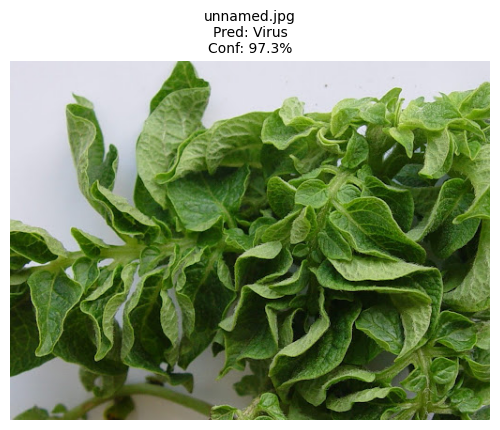

In [8]:
# new_test.py
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
import json
import matplotlib.pyplot as plt

# Конфигурация
MODEL_PATH = 'models/model_quant.tflite'
IMG_SIZE = (224, 224)

# Загрузка имен классов
with open('data/processed/class_indices.json', 'r') as f:
    class_indices = json.load(f)
    CLASS_NAMES = list(class_indices.keys())  # Получаем имена классов в алфавитном порядке

print(f"Загружено {len(CLASS_NAMES)} классов: {CLASS_NAMES}")

# Загрузка модели
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Вывод информации о модели
print("\nИнформация о входных данных модели:")
print(input_details[0])
print("\nИнформация о выходных данных модели:")
print(output_details[0])

# Функция предсказания
def predict_image(image_path):
    # Загрузка изображения
    img = cv2.imread(image_path)
    if img is None:
        return "Error: Could not read image", 0.0, None
    
    # Конвертация цветового пространства и ресайз
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, IMG_SIZE)
    
    # Препроцессинг для EfficientNet
    input_data = preprocess_input(np.expand_dims(img_resized, axis=0).astype(np.float32))
    
    # Для квантованной модели преобразуем в uint8
    input_data = input_data.astype(np.uint8)
    
    # Инференс
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # ДЕКВАНТИЗАЦИЯ ВЫХОДНЫХ ДАННЫХ - КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ!
    # Получаем параметры квантования
    scale, zero_point = output_details[0]['quantization']
    
    # Деквантуем выходные данные
    output_data = (output_data.astype(np.float32) - zero_point) * scale
    
    # Обработка результатов
    predicted_idx = np.argmax(output_data)
    confidence = output_data[0][predicted_idx]
    
    # Получение имени класса
    if predicted_idx < len(CLASS_NAMES):
        class_name = CLASS_NAMES[predicted_idx]
    else:
        class_name = f"Unknown class index: {predicted_idx}"
    
    return class_name, confidence, img

# Тестирование на новых изображениях
test_dir = 'data/new_test_images'
if not os.path.exists(test_dir):
    os.makedirs(test_dir)
    print(f"\nСоздана директория для тестовых изображений: {test_dir}")
    print("Пожалуйста, добавьте тестовые изображения в эту директорию и запустите скрипт снова.")
else:
    print(f"\nТестирование изображений в директории: {test_dir}")
    valid_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not valid_files:
        print("Не найдено изображений для тестирования.")
        print("Добавьте изображения в формате JPG/PNG в директорию и запустите скрипт снова.")
    else:
        # Визуализация результатов
        plt.figure(figsize=(15, 10))
        
        for i, filename in enumerate(valid_files):
            img_path = os.path.join(test_dir, filename)
            class_name, confidence, img = predict_image(img_path)
            
            plt.subplot(2, 3, i+1)
            plt.imshow(img)
            
            # Форматируем confidence как процентное значение
            title = f"{filename}\nPred: {class_name}\nConf: {confidence*100:.1f}%"
            plt.title(title, fontsize=10)
            plt.axis('off')
            
            print(f"Image: {filename} -> Predicted: {class_name} (Confidence: {confidence:.4f})")
        
        plt.tight_layout()
        plt.savefig('models/new_images_test.png')
        plt.show()

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
import json
import os

# Функция для проверки используемой библиотеки
def check_library():
    try:
        import torch
        return "PyTorch"
    except ImportError:
        return "TensorFlow/Keras"

# Функция для проверки нормализации входных данных
def check_normalization(preprocessing_function):
    if preprocessing_function == EfficientNetB0.preprocess_input:
        return "Нормализованы (x/255.0)"
    else:
        return "Неизвестная нормализация"

# Функция для проверки сохраненной модели
def check_model_saving(model_path):
    if model_path.endswith('.tflite'):
        return "Квантованная TFLite модель"
    elif model_path.endswith('.h5'):
        return "Модель в формате HDF5"
    else:
        return "Неизвестный формат модели"

# Основная функция
def main():
    # Проверка используемой библиотеки
    library = check_library()
    print(f"Используемая библиотека: {library}")

    # Проверка нормализации
    preprocessing_function = EfficientNetB0.preprocess_input
    normalization = check_normalization(preprocessing_function)
    print(f"Нормализация входных данных: {normalization}")

    # Проверка сохраненной модели
    model_save_path = 'models/model_quant.tflite'  # Укажите путь к вашей модели
    model_saving = check_model_saving(model_save_path)
    print(f"Сохранение модели: {model_saving}")

if __name__ == "__main__":
    main()



Используемая библиотека: PyTorch


AttributeError: 'function' object has no attribute 'preprocess_input'